# Data Normalization

### Notebook Goals:
Investigate a few data normalization / standardization techniques to improve classical ML Models :)

In [1]:
from src.data.data_loader import load_data, get_train_validation_split
from src.tuning.benchmark import impute_missing_values

df = load_data(use_cached=True)
df, _ = get_train_validation_split(df)

c:\Users\viloh\Documents\nocturnal-hypo-gly-prob-forecast\.venv\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
# p_data = df[df["p_num"] == "p06"]
p_data = df

In [3]:
y_feature = ["bg-0:00"]
x_features = [
    "hr-0:00",
    "steps-0:00",
    "cals-0:00",
    "cob",
    "carb_availability",
    "insulin_availability",
    "iob",
]

# Impute with default methods
p_data = impute_missing_values(p_data, columns=x_features)
p_data = impute_missing_values(p_data, columns=y_feature)

In [4]:
# choose first n hours
time_delta = 15  # 15 min intervals for -06
n_hours = 48
# person_data = p_data.iloc[:int((n_hours * 60) / 15)]
person_data = p_data
person_data.shape

(140160, 15)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting the time series data
plt.figure(figsize=(10, 6))
plt.plot(person_data.index, person_data["bg-0:00"], label="Time Series Data")
plt.title("Time Series Plot")
plt.xlabel("Date")
plt.ylabel("BGL")
plt.legend()
plt.grid(True)
plt.show()

### Idea 1: Fourier Transform + Pruning

The paper [here](https://arxiv.org/pdf/2205.08897#page=12&zoom=100,110,922) describes the idea of "spectral bias". Essentially, the idea is that higher frequency components in the fourier transform act as the *noise*; so we delete frequency components beyond a particulat threshold to eliminate the noise. The lower frequency components can be used to reconstruct the time series data!

In [ ]:
from sktime.transformations.series.fourier import FourierTransform

transformer = FourierTransform()
transformed = transformer.fit_transform(person_data)

#### Visualizing the fourier spectrum
Basic plot of the fourier spectrum. This confirms the spectral bias hypothesis; most of the "amplitude" is in the lower frequency range.

In [ ]:
import matplotlib.pyplot as plt

frequencies = transformed.index
amplitudes = transformed.values

# Plotting the Fourier transformed data
plt.figure(figsize=(10, 6))
plt.stem(frequencies, amplitudes, basefmt=" ")
plt.title("Fourier Transform Plot")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

#### Pop High Frequency Values

Pops the components that have high frequency, and reconstructs the original BGL data with the high frequency values removed

In [ ]:
import numpy as np

frequency_threshold = 3000

# Zero out high-frequency components
filtered_transformed = transformed.copy()
filtered_transformed[filtered_transformed.index > frequency_threshold] = 0

# filtered_transformed
# Perform inverse Fourier Transform to reconstruct the filtered data
filtered_data = np.fft.irfft(
    filtered_transformed.values, n=len(person_data), norm="backward"
)
# Cap time series tail and head to be at most 15
# filtered_data[:300] = np.clip(filtered_data[:300], None, 15)  # Cap first 10 values
# filtered_data[-300:] = np.clip(filtered_data[-300:], None, 15)  # Cap last 10 values
# Create a new dataframe for filtered data
filtered_data += np.mean(person_data["bg-0:00"])
filtered_df = pd.Series(filtered_data, index=person_data.index)


# Plot original and filtered data
plt.figure(figsize=(14, 7))
plt.plot(person_data.index, person_data["bg-0:00"], label="Original Data")
# plt.plot(person_data.index, series, label="Original Data w/ Wavelet")
plt.plot(filtered_df.index, filtered_df, label="Filtered Data", linestyle="--")
plt.title("Original and Filtered Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
# plt.show()

## Idea 2: Wavelet Transform

I think that extensive use of linear imputation is causing some bad fourier transform coefficients. So maybe run a wavelet transform that can get the weighted "moving average" based on a function $\psi$

In [ ]:
from sktime.transformations.panel.dwt import DWTTransformer

transformer = DWTTransformer(num_levels=1)
transformed = transformer.fit_transform(person_data["bg-0:00"])

In [5]:
import matplotlib.pyplot as plt


def plot_items(data):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data, label="Filtered Data", linestyle="--")
    plt.title("Original and Filtered Time Series Data")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)

In [ ]:
person_data = p_data.iloc[:288]  # choose a few hours (36 hrs)

The cell below is just a test of implementing a custom wavelet transformer with Sktime's base class. It is a duplicate of the cell below it

In [6]:
import pandas as pd
from src.data.data_transforms import apply_wavelet_transform

inp = pd.Series(person_data["bg-0:00"])
inp.head()
# transformer = WaveletTransformer(window_len=288)
# transformed = transformer.fit_transform(inp)
transformed = apply_wavelet_transform(p_data, wavelet_window=288)
# person_data['bg-0:00'].head()

c:\Users\viloh\Documents\nocturnal-hypo-gly-prob-forecast\.venv\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
99   99
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
288   288
10   10
288   288
288   288
288   288
288   288
288 

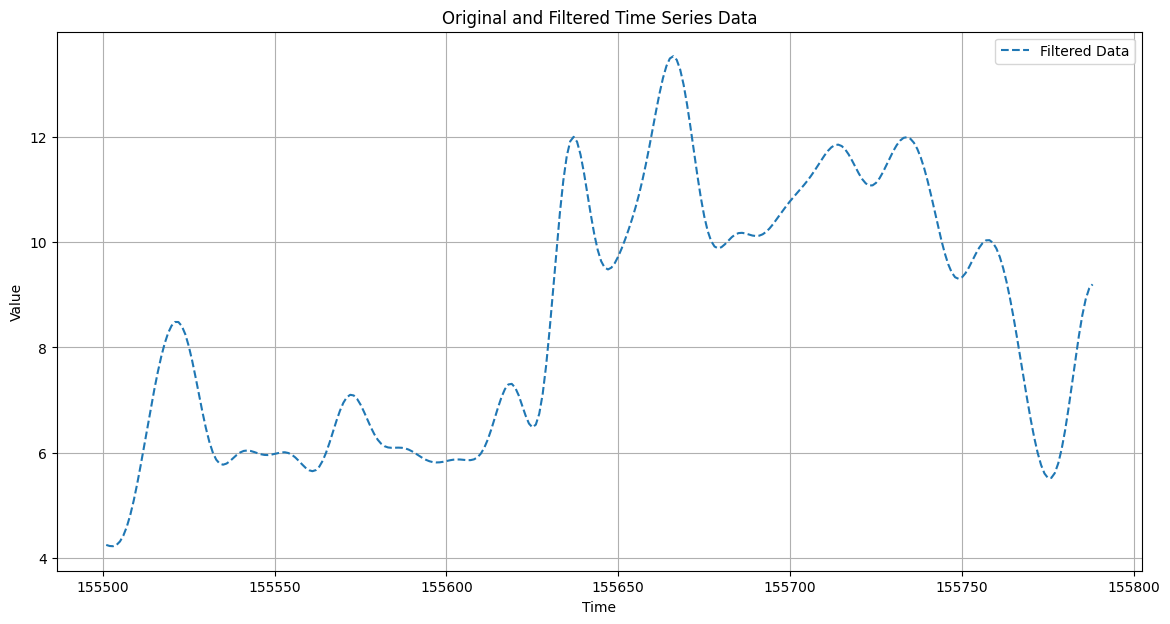

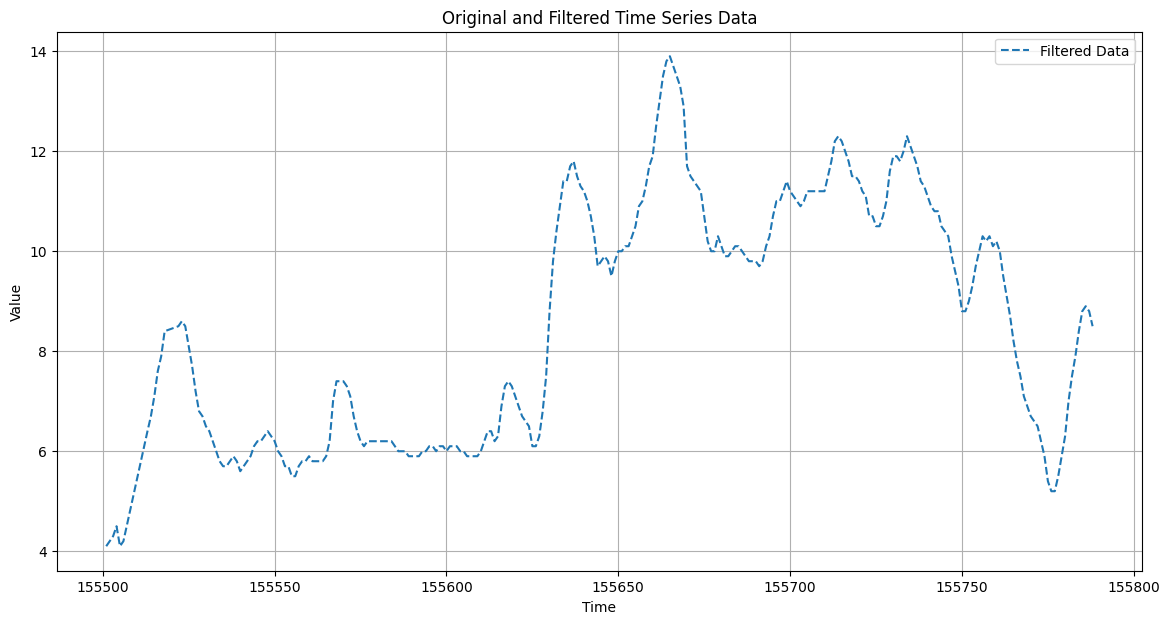

In [9]:
plot_items(transformed[transformed["p_num"] == "p12"]["bg-0:00"].iloc[0:288])
plot_items(person_data[person_data["p_num"] == "p12"]["bg-0:00"].iloc[0:288])

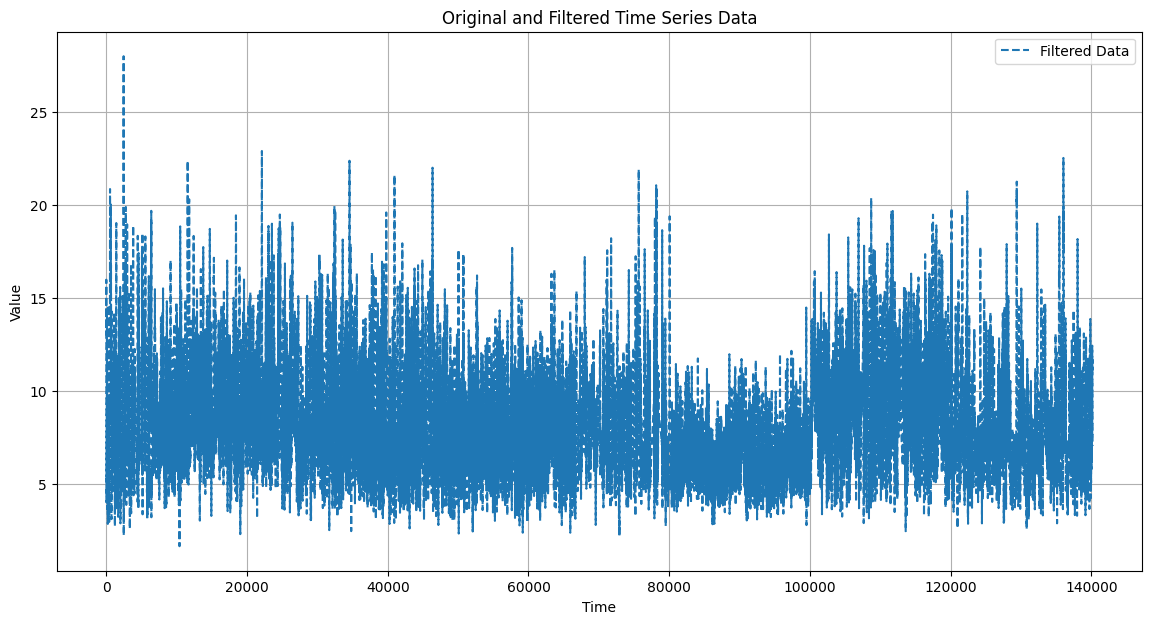

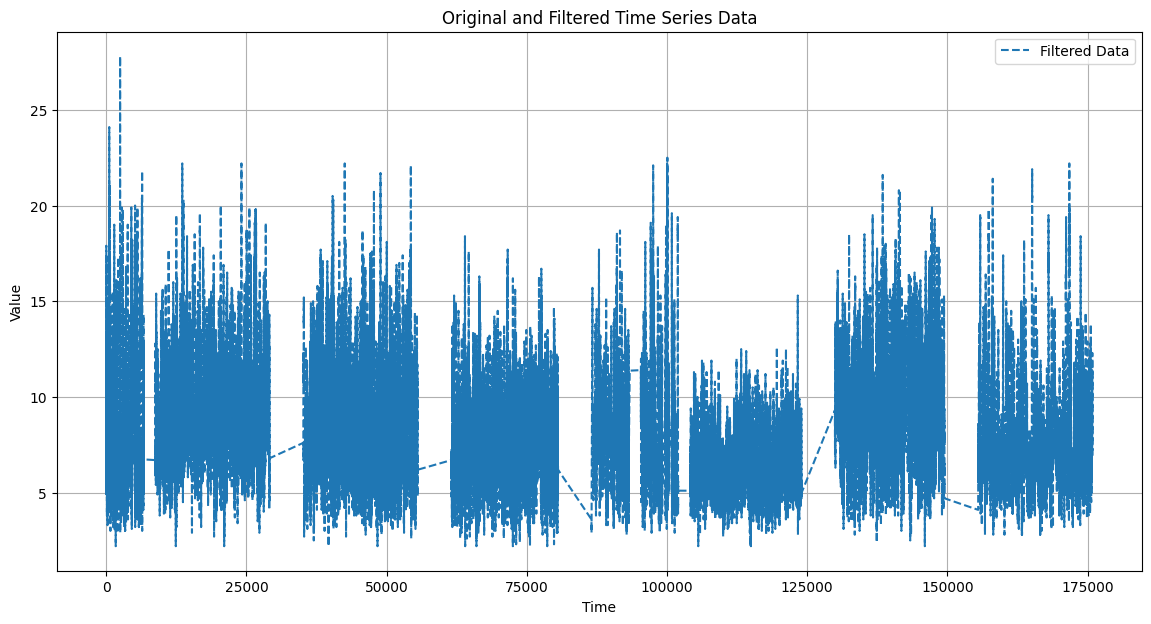

In [13]:
import pywt
import numpy as np

wavelet = "sym16"  # you ccan find all wavelets in pywt.wavelist(kind='discrete') that is useful for our problem

# returns (cA_n, cD_n,...,cD1) where n is the 'levels', cA_n are the approx coeffs, cD's are the detailed coeffs
coeffs = pywt.wavedec(person_data["bg-0:00"], wavelet, level=3)

sigma = np.median(np.max(coeffs[-1])) / 0.6745
threshold = sigma * np.sqrt(2 * np.log(len(person_data)))

# apply thresholding to detail coefficients (keeping the approximation coefficients intact)- cA captures low-frequency stuff and cD's capture high frequency. We can smooth
# the data by removing part of the cD's (i.e zero it)
coeffs_new = coeffs.copy()
coeffs_new[1:] = [pywt.threshold(c, threshold, mode="hard") for c in coeffs[1:]]

# reconstruct the signal and plot!
smoothed_signal = pywt.waverec(coeffs_new, wavelet)
series = pd.Series(smoothed_signal)

# plot_items(series.iloc[0:300])
# plot_items(person_data["bg-0:00"].iloc[0:300])
plot_items(series)
plot_items(person_data["bg-0:00"])

## Idea 3: Moving Average, Exponential Smoothing
I shall attempt to see how moving average and exponential smoothing perform here!

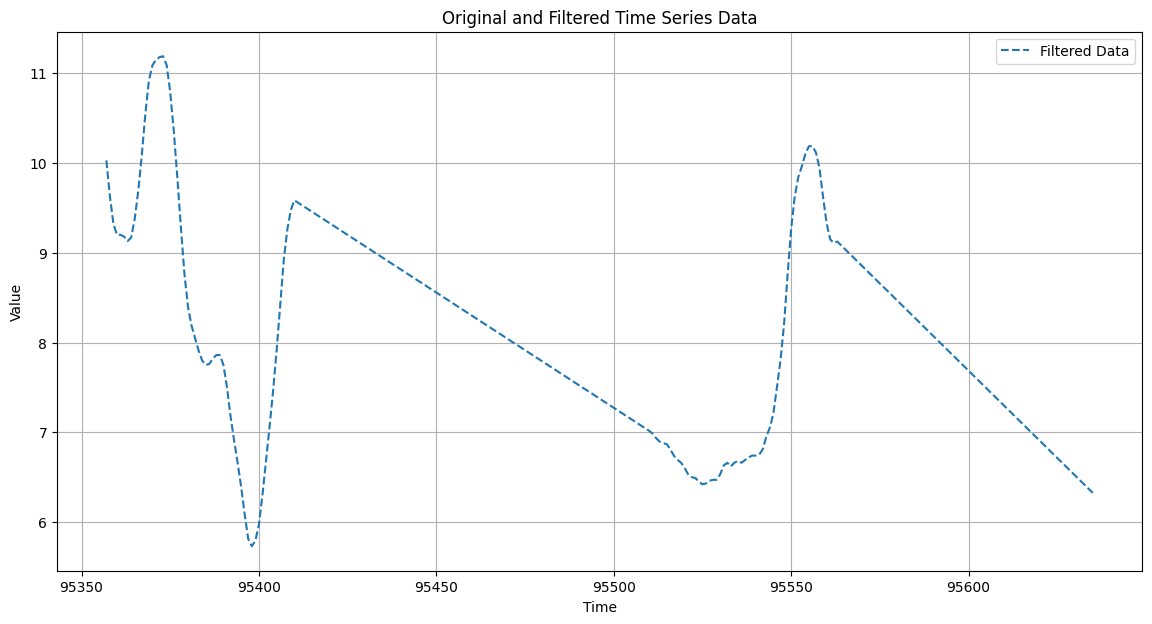

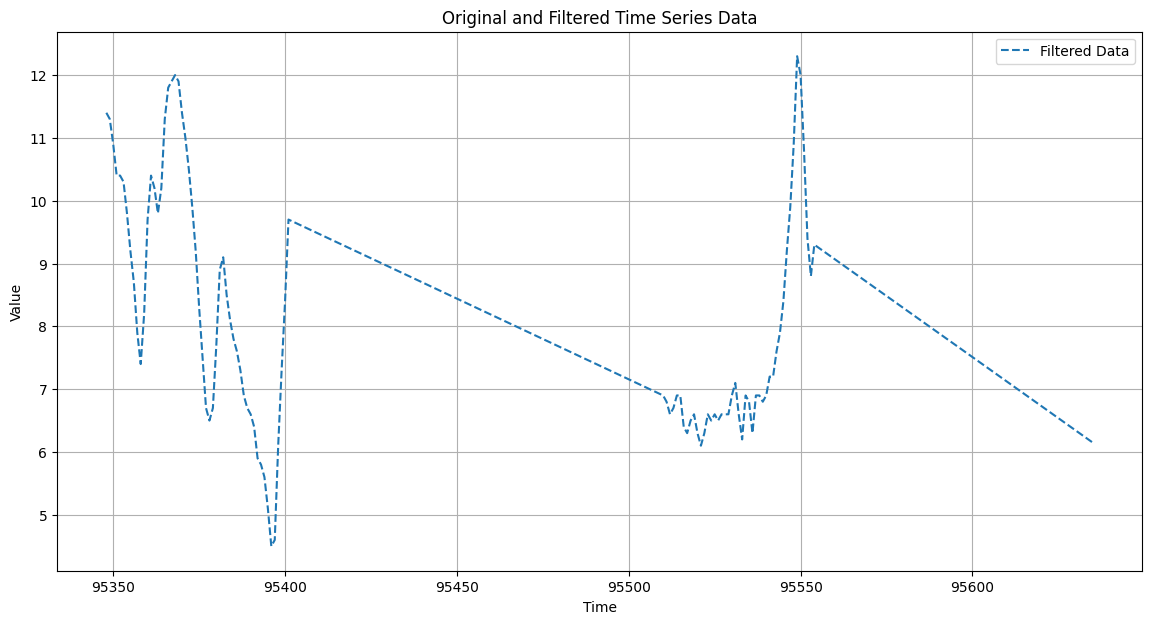

In [15]:
def moving_average(series, window_size):
    return series.rolling(window=window_size).mean()


smoothed_series = moving_average(person_data["bg-0:00"], 10)
plot_items(smoothed_series[0:288])
plot_items(person_data["bg-0:00"].iloc[0:288])

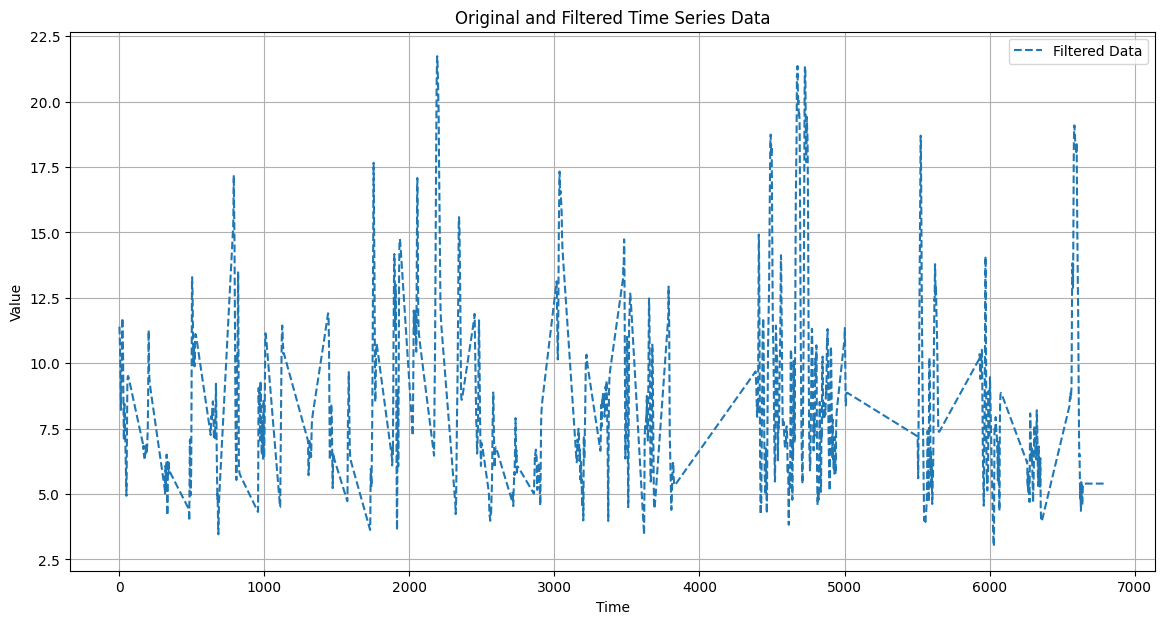

In [13]:
def exponential_smoothing(series, alpha):
    # perform exponential smoothing
    result = [series.iloc[0]]
    for n in range(1, len(series)):
        result.append(alpha * series.iloc[n] + (1 - alpha) * result[n - 1])
    return pd.Series(result)


smoothed = exponential_smoothing(person_data["bg-0:00"], alpha=0.4)
plot_items(smoothed)